In [1]:
import logging
import argparse
from sys import argv, exit, path
from os import system
from os.path import exists, dirname
import datetime
import findspark  # find spark home directory
findspark.init('/usr/hdp/current/spark2-client')
from pyspark.sql import HiveContext
from pyspark.sql.functions import pandas_udf, PandasUDFType

import pandas as pd

path.insert(0, "/home/prod/git/common/config_utils")
from load_user_config import load_config_from_file, convert_namedtuple_to_dict
path.insert(0, "/home/prod/git/common/logging")
from user_logging import assign_log_handler, close_log_handler
path.insert(0, "/home/prod/git/common/pyspark_utils")
from get_spark import get_spark
path.insert(0, "/home/prod/git/common/collect_raw_data_utils")
from get_guobiao_raw_data_missing_days import get_guobiao_raw_data_missing_days
from data_collection import get_raw_records_in_spark
from aggregate_raw_data import aggregate_raw_data
import pyspark.sql.functions as F

In [2]:
df_pdf = pd.read_csv("/home/wchen/LNAA2AA11K5028947_all.csv")

In [3]:
df_pdf.columns = [x.split('.')[1] for x in df_pdf.columns]
df_pdf.head()

,vin,vintype,ts,veh_st,veh_charge_st,veh_runmode,veh_spd,veh_odo,veh_volt,veh_curr,...,esd_curr,esd_sc_cnt,esd_frame_start,esd_frame_sc_cnt,esd_frame_sc_list,esd_temp_subsys_cnt,esd_temp_subsys_seq,esd_temp_probe_cnt,esd_temp_probe_list,day
0,LNAA2AA11K5028947,A26,1576299255000,1,3,1,0.0,0.0,326.3,0.0,...,0.0,92,1,92,3.567|3.568|3.568|3.570|3.567|3.568|3.567|3.56...,1,1,32,22|23|22|22|23|22|23|22|22|22|23|22|22|22|22|2...,20191214
1,LNAA2AA11K5028947,A26,1576299265000,1,3,1,0.0,0.0,326.3,0.7,...,0.7,92,1,92,3.566|3.568|3.567|3.569|3.566|3.567|3.565|3.56...,1,1,32,22|23|22|22|23|22|23|22|22|22|23|22|22|22|22|2...,20191214
2,LNAA2AA11K5028947,A26,1576299275000,1,3,1,0.0,0.0,326.3,0.7,...,0.7,92,1,92,3.566|3.568|3.566|3.569|3.566|3.566|3.565|3.56...,1,1,32,22|23|22|22|23|22|23|22|22|22|23|22|22|22|23|2...,20191214
3,LNAA2AA11K5028947,A26,1576299285000,1,3,1,0.0,0.0,326.3,0.7,...,0.7,92,1,92,3.566|3.568|3.567|3.568|3.565|3.568|3.566|3.56...,1,1,32,22|23|22|22|23|22|23|22|22|22|23|22|22|22|22|2...,20191214
4,LNAA2AA11K5028947,A26,1576299295000,1,3,1,0.0,0.0,326.3,0.7,...,0.7,92,1,92,3.566|3.567|3.568|3.569|3.565|3.567|3.565|3.56...,1,1,32,22|23|22|22|23|22|23|22|22|22|23|22|22|22|22|2...,20191214


In [4]:
vintype ='A26'
#num_modules = tmp["NUMBER_OF_TEMP_MODULES"][vintype]
num_modules = 32

In [5]:
#df_pdf = df_pdf.rename({'a26_gb_orc.esd_temp_probe_list':'esd_temp_probe_list'})

In [6]:
temperature_list = ["sensor_" + str(s) for s in range(1, num_modules+1)]

In [7]:
voltage_list = ["voltage_" + str(s) for s in range(1, 92+1)]

In [8]:
df_pdf[temperature_list] = df_pdf.esd_temp_probe_list.str.split("|",expand=True) 

In [9]:
df_pdf[voltage_list] = df_pdf.esd_frame_sc_list.str.split("|",expand=True) 

In [10]:
import numpy as np
null_signals = np.all(pd.isnull(df_pdf[temperature_list]), axis = 1)
df_pdf[temperature_list] = df_pdf[temperature_list].loc[~null_signals].astype(np.float)

In [11]:
null_signals = np.all(pd.isnull(df_pdf[voltage_list]), axis = 1)
df_pdf[voltage_list] = df_pdf[voltage_list].loc[~null_signals].astype(np.float)

In [12]:
#df_pdf = df_pdf.reset_index()

def convert_ts_to_datetime(ts_series):
    """
    This function converts timestamps into datetime objects

    Parameters
    ----------
    ts_series : Pandas Series of timestamps

    Returns
    ----------
    datetime_series : Pandas Series of strings of datetimes

    Notes
    -----
    This function can accept these ts units: s, ms, us, ns
    """

    available_units = {19:'ns', 16:'us', 13:'ms', 10:'s'}
    time_zone = 'Asia/Hong_Kong'

    def _epoch_time_converter(t):
        t = str(t)
        if len(t) in available_units.keys():
            unit = available_units[len(t)]
        else:
            raise AttributeError('{} is not in valid epoch time format'.format(t))
        return pd.to_datetime(t, unit=unit, utc=True).tz_convert(time_zone)

    digits = ts_series.astype(str).str.len()
    # only one unit of ts is in the whole series,
    # so use vectorized method to convert
    if len(digits.unique()) == 1:
        if digits.iloc[0] in available_units.keys():
            unit_of_ts = available_units[digits.iloc[0]]
            datetime_series = pd.to_datetime(ts_series, unit=unit_of_ts,
                                             utc=True).dt.tz_convert(time_zone)
        else:
            raise AttributeError('input ts is not in valid epoch time format')

    # several units of ts found,
    # has to convert to datetime using apply (i.e., one row at a time)
    else:
        datetime_series = ts_series.apply(_epoch_time_converter)

    return datetime_series
df_pdf['ts'] = convert_ts_to_datetime(df_pdf['ts'])

In [13]:
df_pdf = df_pdf.set_index('ts')

In [14]:
df_pdf.sort_index(inplace=True)

In [15]:
df_pdf.head()

,vin,vintype,veh_st,veh_charge_st,veh_runmode,veh_spd,veh_odo,veh_volt,veh_curr,veh_soc,...,voltage_83,voltage_84,voltage_85,voltage_86,voltage_87,voltage_88,voltage_89,voltage_90,voltage_91,voltage_92
ts,,,,,,,,,,,,,,,,,,,,,
2019-12-14 12:54:15+08:00,LNAA2AA11K5028947,A26,1,3,1,0.0,0.0,326.3,0.0,29,...,3.565,3.568,3.565,3.567,3.567,3.566,3.568,3.567,3.568,3.568
2019-12-14 12:54:25+08:00,LNAA2AA11K5028947,A26,1,3,1,0.0,0.0,326.3,0.7,29,...,3.564,3.566,3.563,3.566,3.566,3.564,3.566,3.567,3.567,3.566
2019-12-14 12:54:35+08:00,LNAA2AA11K5028947,A26,1,3,1,0.0,0.0,326.3,0.7,29,...,3.564,3.566,3.563,3.566,3.566,3.565,3.566,3.567,3.567,3.566
2019-12-14 12:54:45+08:00,LNAA2AA11K5028947,A26,1,3,1,0.0,0.0,326.3,0.7,29,...,3.564,3.566,3.564,3.566,3.566,3.565,3.566,3.566,3.566,3.566
2019-12-14 12:54:55+08:00,LNAA2AA11K5028947,A26,1,3,1,0.0,0.0,326.3,0.7,29,...,3.564,3.566,3.564,3.566,3.566,3.565,3.566,3.566,3.566,3.567


Text(0.5,0,'ts')

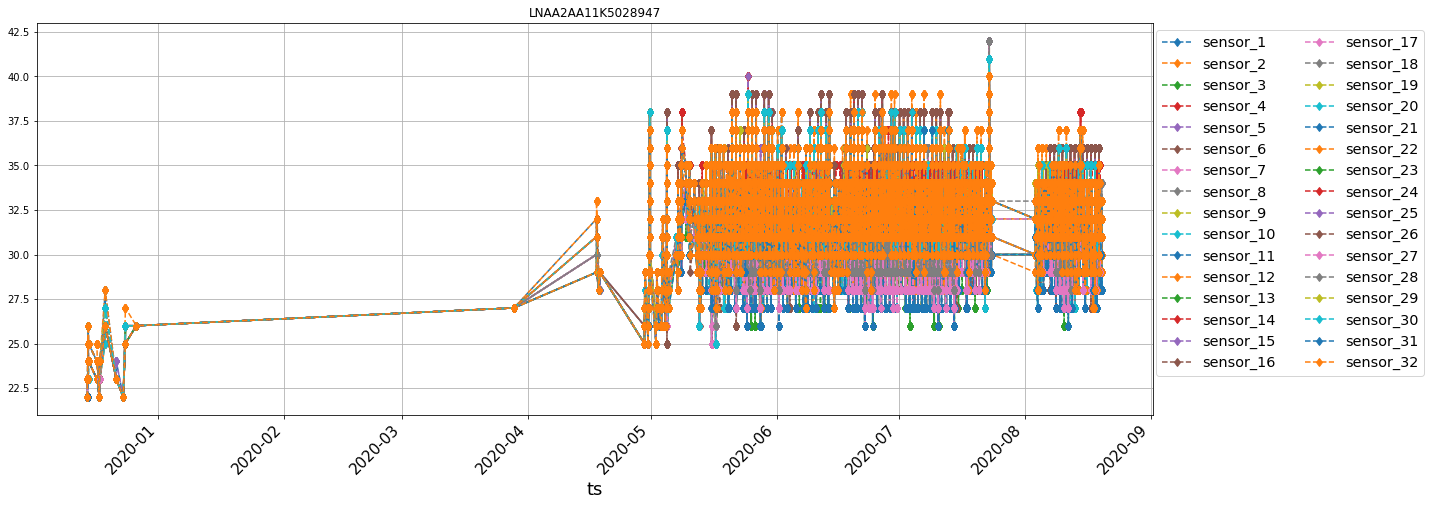

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
df_pdf[temperature_list].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    #xlim=(earliest_date_ - timedelta(2), prod_date_ + timedelta(3)),
    title='LNAA2AA11K5028947')
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.xticks(fontsize=15, rotation=45)
plt.xlabel('ts', fontsize=18)

In [17]:
length = len(df_pdf) * 0.7
print length

355676.3


In [18]:
print len(df_pdf) 

508109


Text(0.5,0.98,'LNAA2AA11K5028947')

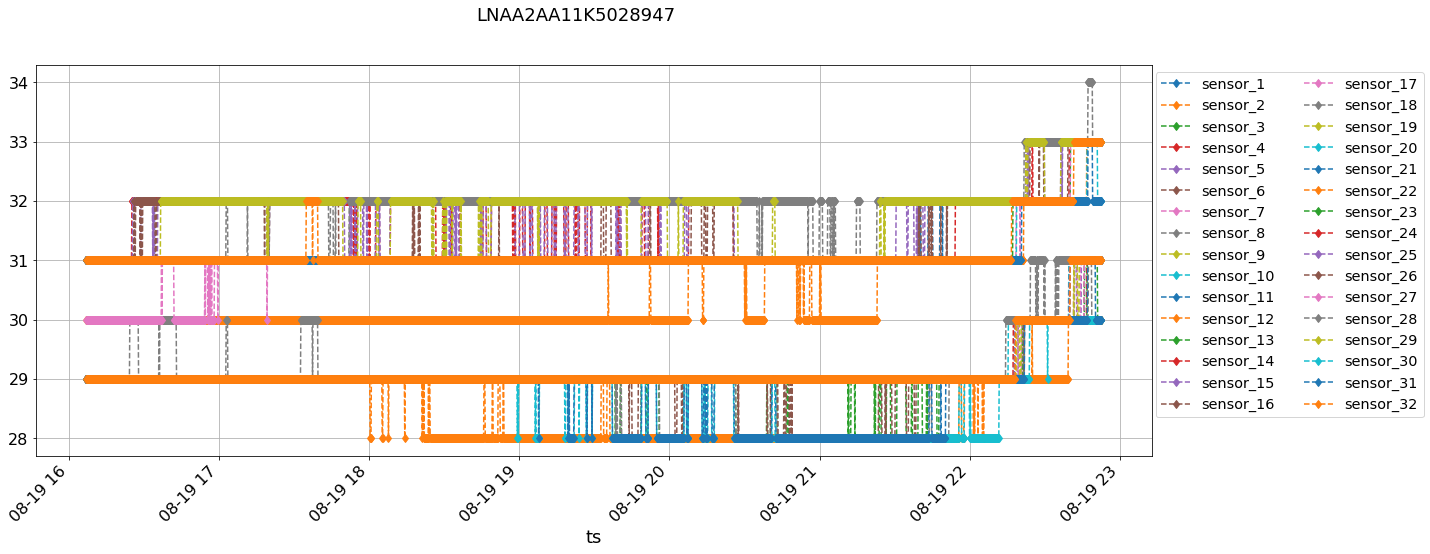

In [55]:
%matplotlib inline
df_pdf[temperature_list].iloc[505676:,:].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    #xlim=(earliest_date_ - timedelta(2), prod_date_ + timedelta(3)),
    #title='LNAA2AA11K5027328', fontsize=18
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5028947', fontsize=18)

In [20]:
train = df_pdf.iloc[0:355676,:][temperature_list]
test = df_pdf.iloc[355677:,:][temperature_list]

In [21]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df_pdf[temperature_list], test_size=0.2)
#train.count()

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
mse = {}
r2 = {}

In [24]:
for i in range(1, 33):
    print("Process module " + str(i))
    y = train['sensor_' + str(i)]
    X = train.drop(['sensor_' + str(i)], axis=1)
    reg = LinearRegression().fit(X, y)
    print("Done with training module " + str(i))
    reg.score(X, y)
    X_test = test.drop(['sensor_' + str(i)], axis=1)        
    y_pred = reg.predict(X_test)
    print("Done with testing module " + str(i))
    mse_value = mean_squared_error(test['sensor_' + str(i)], y_pred)
    mse[i] = mse_value
    r2_value = r2_score(test['sensor_' + str(i)], y_pred)
    r2[i] = r2_value

Process module 1
Done with training module 1
Done with testing module 1
Process module 2
Done with training module 2
Done with testing module 2
Process module 3
Done with training module 3
Done with testing module 3
Process module 4
Done with training module 4
Done with testing module 4
Process module 5
Done with training module 5
Done with testing module 5
Process module 6
Done with training module 6
Done with testing module 6
Process module 7
Done with training module 7
Done with testing module 7
Process module 8
Done with training module 8
Done with testing module 8
Process module 9
Done with training module 9
Done with testing module 9
Process module 10
Done with training module 10
Done with testing module 10
Process module 11
Done with training module 11
Done with testing module 11
Process module 12
Done with training module 12
Done with testing module 12
Process module 13
Done with training module 13
Done with testing module 13
Process module 14
Done with training module 14
Done 

In [25]:
mse_df = pd.DataFrame.from_dict(mse, orient='index')
mse_df = mse_df.reset_index()
print(type(mse_df))
mse_df.columns = ['index', 'mse']
mse_df.sort_values(by=['mse'])

<class 'pandas.core.frame.DataFrame'>


,index,mse
19,20,0.052518
16,17,0.054680
7,8,0.058077
3,4,0.060692
6,7,0.064618
13,14,0.065829
5,6,0.066641
4,5,0.069030
8,9,0.069414
24,25,0.070021


In [61]:
train_v = df_pdf.iloc[0:355676,:][voltage_list]
test_v = df_pdf.iloc[355677:,:][voltage_list]
#train_v,test_v = train_test_split(df_pdf[voltage_list], test_size=0.2)
mse_v = {}
r2_v = {}

for i in range(1, 93):
    print("Process module " + str(i))
    y = train_v['voltage_' + str(i)]
    X = train_v.drop(['voltage_' + str(i)], axis=1)
    reg = LinearRegression().fit(X, y)
    print("Done with training module " + str(i))
    reg.score(X, y)
    X_test = test_v.drop(['voltage_' + str(i)], axis=1)        
    y_pred = reg.predict(X_test)
    print("Done with testing module " + str(i))
    mse_value = mean_squared_error(test_v['voltage_' + str(i)], y_pred)
    
    mse_v[i] = ((test_v['voltage_' + str(i)] - y_pred) ** 2).nlargest(10).mean()
    r2_value = r2_score(test_v['voltage_' + str(i)], y_pred)
    r2_v[i] = r2_value

pd.DataFrame.from_dict(mse_v, orient='index')

Process module 1
Done with training module 1
Done with testing module 1
Process module 2
Done with training module 2
Done with testing module 2
Process module 3
Done with training module 3
Done with testing module 3
Process module 4
Done with training module 4
Done with testing module 4
Process module 5
Done with training module 5
Done with testing module 5
Process module 6
Done with training module 6
Done with testing module 6
Process module 7
Done with training module 7
Done with testing module 7
Process module 8
Done with training module 8
Done with testing module 8
Process module 9
Done with training module 9
Done with testing module 9
Process module 10
Done with training module 10
Done with testing module 10
Process module 11
Done with training module 11
Done with testing module 11
Process module 12
Done with training module 12
Done with testing module 12
Process module 13
Done with training module 13
Done with testing module 13
Process module 14
Done with training module 14
Done 

,0
1,0.000006
2,0.000005
3,0.000005
4,0.000005
5,0.000005
6,0.000004
7,0.000063
8,0.000004
9,0.000005
10,0.000005


In [60]:
pd.set_option('display.max_row', 1000)

# Individual sensor study

充电状态分为 1：停车充电，2：行驶充电，3：表充电状态，4：充电完成
数据中没有状态2：行驶充电！
The earlist recorded day: 20191214
The last recorded day: 20200819


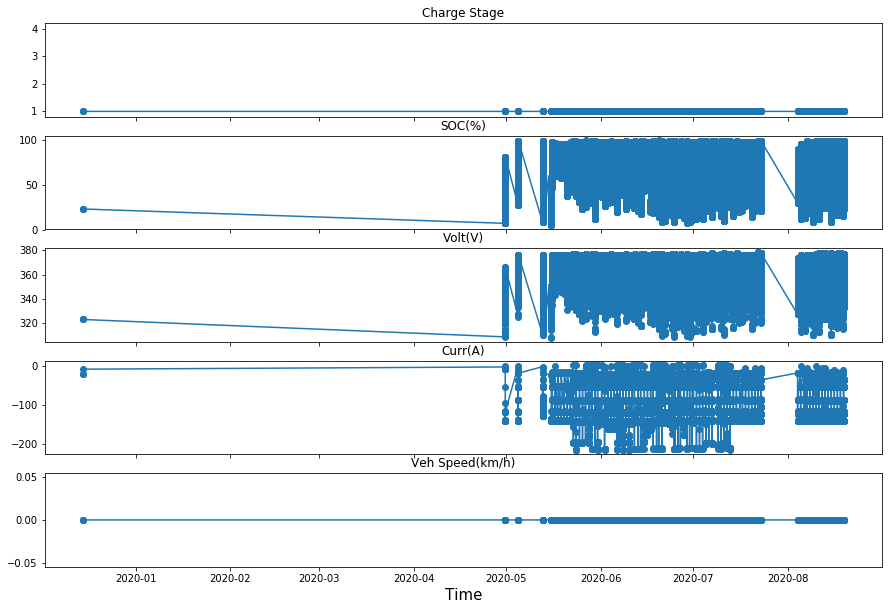

In [27]:
 print('充电状态分为 1：停车充电，2：行驶充电，3：表充电状态，4：充电完成')
print('数据中没有状态2：行驶充电！')
df2 = df_pdf[(df_pdf['veh_charge_st']==1)]  # & df[' esd_curr']>=0

print("The earlist recorded day: {}".format(df_pdf.iloc[0]['day']))
print("The last recorded day: {}".format(df_pdf.iloc[-1]['day']))

df2=df2.reset_index()
#datetime = convert_ts_to_datetime(df2['ts'])
datetime = df2['ts']
x_values = datetime # df2.index.values

# plt.rcParams['figure.figsize'] = [15, 10]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,sharex='col',figsize = [15, 10])
ax1.plot(x_values, df2['veh_charge_st'],'-o')
ax1.set_title('Charge Stage')
ax1.set_ylim(0.8,4.2)
ax2.plot(x_values, df2['veh_soc'],'-o')
ax2.set_title('SOC(%)')
ax3.plot(x_values, df2['esd_volt'],'-o')
ax3.set_title('Volt(V)')
#ax3.set_ylim(0, 5)
ax4.plot(x_values, df2['esd_curr'],'-o')
ax4.set_title('Curr(A)')
ax5.plot(x_values, df2['veh_spd'],'-o')
ax5.set_title('Veh Speed(km/h)')
ax5.set_xlabel('Time',size=15)
plt.show()

In [28]:
result_list = []

In [29]:
#df_pdf = df_pdf.drop(df_pdf.columns[0], axis=1)
#df_pdf.head()

In [30]:
schema = "sensor_id int"
schema += ", fast_charging string, slow_charging string, driving string"

columns = [element.split(" ")[0] for element in \
           schema.split(", ")]

In [31]:
filter1 = df_pdf['veh_curr'] < -30
filter2 = df_pdf['veh_charge_st'] == 1
fast_charging_conds = filter1 & filter2

In [32]:
filter1 = df_pdf['veh_curr'] >= -30
filter2 = df_pdf['veh_curr'] < 0
filter3 = df_pdf['veh_charge_st'] == 1
slow_charging_conds = filter1 & filter2 & filter3

In [33]:
filter4 = df_pdf['veh_charge_st'] == 3
filter5 = df_pdf['veh_st'] == 1
driving_conds = filter4 & filter5

In [34]:
def _compute_max_rate(df, temperature_list, period):   
    #df[df >= 85] = np.nan   
    #df[df <= -40] = np.nan   
    df = df.reset_index()
    """
    # filter out bad records with average jump greater than 10 degree across all sensors
    temp_pre_diff_10s = df.mean(axis=1).diff(periods=1).fillna(0)
    ts_pre_diff = df["ts"].diff(periods=1).fillna(0).dt.seconds
    mask = (temp_pre_diff_10s > -10) & (temp_pre_diff_10s < 10)
    # only filter out those recods with ts diff not higher than 11 seconds under the above condition
    mask = mask | (ts_pre_diff > 11)
    df = df[mask]
    #"""
    
    
     ###
    df['ts'] = df['ts'].dt.tz_localize(None)###
    df = df.sort_values(by='ts')###
    df = df.set_index(['ts'], inplace=False)###
    ts_diff = pd.Series(df.index, index=df.index).diff(periods=period).iloc[1:]###
    ts_diff = ts_diff.dt.seconds.div(60, fill_value=0)

    temp_diff = df[temperature_list].max(axis=1).diff(periods=period).iloc[1:]
    #x.append(temp_diff)
    rate_df = temp_diff.div(ts_diff, axis=0)
    rate_df_increasing = rate_df#[rate_df > 1]
    
    thrd = 0.9
    if period == 30:
        thrd = 4.9
    mask = ts_diff > thrd
    #rate_df_increasing = rate_df_increasing[mask]
    
    #rate_series = pd.DataFrame(sorted(it.chain(*rate_df_increasing.values)))
    result_list.append(rate_df)
    
    if len(rate_df_increasing):
        ind_max = rate_df_increasing.idxmax()

        rate = round(rate_df_increasing.loc[ind_max], 2)
        temp_diff = round(temp_diff.loc[ind_max], 2)
        time_diff = round(ts_diff.loc[ind_max], 3)
    else:
        rate, temp_diff, time_diff, ind_max = None, None, None, None

    return rate, temp_diff, time_diff, ind_max

In [35]:
return_dict = {}

def compute_rate(sensor_id):
    return_dict[sensor_id] = {}
    temp_dict = return_dict[sensor_id]
    fast_charging_df = df_pdf[fast_charging_conds].copy()
    if not fast_charging_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(fast_charging_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["fast_charging"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["fast_charging"] = ""
    else:
        temp_dict["fast_charging"] = ""

    slow_charging_df = df_pdf[slow_charging_conds].copy()
    if not slow_charging_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(slow_charging_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["slow_charging"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["slow_charging"] = ""
    else:
        temp_dict["slow_charging"] = ""

    driving_df = df_pdf[driving_conds].copy()
    if not driving_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(driving_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["driving"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["driving"] = ""
    else:
        temp_dict["driving"] = ""
    print(temp_dict)

for i in range(1, 33):
    print("start module_" + str(i))
    compute_rate('sensor_' + str(i))
    print("done with module_" + str(i))
return_df_all = pd.DataFrame(return_dict, columns=columns, index=[None])

start module_1
{'fast_charging': '3.0:3.0:1.0:2020-06-02 04:25:15', 'driving': '1.0:1.0:1.0:2019-12-14 12:58:55', 'slow_charging': '1.0:1.0:1.0:2020-06-09 04:22:15'}
done with module_1
start module_2
{'fast_charging': '3.0:3.0:1.0:2020-05-30 21:44:55', 'driving': '1.0:1.0:1.0:2019-12-14 18:21:55', 'slow_charging': '1.0:1.0:1.0:2020-04-30 16:24:15'}
done with module_2
start module_3
{'fast_charging': '3.0:3.0:1.0:2020-05-26 23:07:55', 'driving': '1.0:1.0:1.0:2019-12-14 15:04:25', 'slow_charging': '1.0:1.0:1.0:2020-05-13 00:36:45'}
done with module_3
start module_4
{'fast_charging': '3.0:3.0:1.0:2020-05-26 23:07:55', 'driving': '2.0:2.0:1.0:2019-12-14 18:34:55', 'slow_charging': '1.0:1.0:1.0:2020-05-13 00:39:05'}
done with module_4
start module_5
{'fast_charging': '3.0:3.0:1.0:2020-05-26 23:07:55', 'driving': '1.0:1.0:1.0:2019-12-14 18:21:35', 'slow_charging': '1.0:1.0:1.0:2020-04-30 15:35:05'}
done with module_5
start module_6
{'fast_charging': '3.0:3.0:1.0:2020-05-30 21:44:55', 'drivin

In [36]:
#print(return_dict)
return_df_all = pd.DataFrame(return_dict)#, columns=columns, index=[None])

In [37]:
return_df_all.head()

,sensor_1,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,...,sensor_3,sensor_30,sensor_31,sensor_32,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9
driving,1.0:1.0:1.0:2019-12-14 12:58:55,1.0:1.0:1.0:2019-12-14 18:34:15,1.0:1.0:1.0:2019-12-14 18:34:15,1.2:1.0:0.833:2020-08-06 06:15:35,1.0:1.0:1.0:2019-12-14 14:29:55,1.0:1.0:1.0:2019-12-14 14:14:25,2.0:2.0:1.0:2019-12-14 18:34:55,1.0:1.0:1.0:2019-12-14 12:56:25,1.0:1.0:1.0:2019-12-14 14:10:35,1.0:1.0:1.0:2019-12-14 13:01:55,...,1.0:1.0:1.0:2019-12-14 15:04:25,1.0:1.0:1.0:2019-12-14 14:56:25,1.0:1.0:1.0:2019-12-14 15:06:05,1.0:1.0:1.0:2019-12-14 14:43:35,2.0:2.0:1.0:2019-12-14 18:34:55,1.0:1.0:1.0:2019-12-14 18:21:35,1.0:1.0:1.0:2019-12-14 13:02:55,1.0:1.0:1.0:2019-12-14 17:49:05,1.2:1.0:0.833:2020-07-08 20:11:35,1.0:1.0:1.0:2019-12-14 14:09:25
fast_charging,3.0:3.0:1.0:2020-06-02 04:25:15,3.0:3.0:1.0:2020-06-02 04:24:55,3.0:3.0:1.0:2020-05-30 21:45:05,3.0:3.0:1.0:2020-05-29 23:57:15,3.0:3.0:1.0:2020-05-30 21:45:05,3.0:3.0:1.0:2020-05-30 21:45:05,3.0:3.0:1.0:2020-05-28 22:49:35,3.0:3.0:1.0:2020-05-30 21:45:05,3.0:3.0:1.0:2020-05-30 21:45:05,3.0:3.0:1.0:2020-05-29 23:57:15,...,3.0:3.0:1.0:2020-05-26 23:07:55,2.0:2.0:1.0:2020-05-25 23:23:45,2.0:2.0:1.0:2020-05-26 23:07:45,2.0:2.0:1.0:2020-05-25 23:23:45,3.0:3.0:1.0:2020-05-26 23:07:55,3.0:3.0:1.0:2020-05-26 23:07:55,3.0:3.0:1.0:2020-05-30 21:44:55,3.0:3.0:1.0:2020-05-30 21:44:55,3.0:3.0:1.0:2020-05-30 21:44:55,3.0:3.0:1.0:2020-05-30 21:45:05
slow_charging,1.0:1.0:1.0:2020-06-09 04:22:15,1.0:1.0:1.0:2020-05-28 22:47:25,1.0:1.0:1.0:2020-06-11 04:32:05,1.0:1.0:1.0:2020-07-05 05:32:05,1.0:1.0:1.0:2020-05-27 23:33:05,1.0:1.0:1.0:2020-07-04 04:33:25,1.0:1.0:1.0:2020-04-30 16:01:15,1.0:1.0:1.0:2020-04-30 16:06:35,1.0:1.0:1.0:2020-06-20 15:55:05,1.0:1.0:1.0:2020-05-23 22:21:15,...,1.0:1.0:1.0:2020-05-13 00:36:45,1.0:1.0:1.0:2020-05-13 00:54:25,1.0:1.0:1.0:2020-06-19 03:56:05,1.0:1.0:1.0:2020-06-13 22:46:35,1.0:1.0:1.0:2020-05-13 00:39:05,1.0:1.0:1.0:2020-04-30 15:35:05,1.0:1.0:1.0:2020-04-30 15:45:15,1.0:1.0:1.0:2020-05-13 00:40:25,1.0:1.0:1.0:2020-04-30 15:37:45,1.0:1.0:1.0:2020-07-07 22:39:25


In [38]:
df_res = return_df_all.T

In [39]:
pd.set_option('display.max_rows', None)

In [40]:
df_res["driving_rate"] = df_res["driving"].str.split(":", n = 1, expand = True)[0]
df_res["fast_charging_rate"] = df_res["fast_charging"].str.split(":", n = 1, expand = True)[0]
df_res["slow_charging_rate"] = df_res["slow_charging"].str.split(":", n = 1, expand = True)[0]
df_res

,driving,fast_charging,slow_charging,driving_rate,fast_charging_rate,slow_charging_rate
sensor_1,1.0:1.0:1.0:2019-12-14 12:58:55,3.0:3.0:1.0:2020-06-02 04:25:15,1.0:1.0:1.0:2020-06-09 04:22:15,1.0,3.0,1.0
sensor_10,1.0:1.0:1.0:2019-12-14 18:34:15,3.0:3.0:1.0:2020-06-02 04:24:55,1.0:1.0:1.0:2020-05-28 22:47:25,1.0,3.0,1.0
sensor_11,1.0:1.0:1.0:2019-12-14 18:34:15,3.0:3.0:1.0:2020-05-30 21:45:05,1.0:1.0:1.0:2020-06-11 04:32:05,1.0,3.0,1.0
sensor_12,1.2:1.0:0.833:2020-08-06 06:15:35,3.0:3.0:1.0:2020-05-29 23:57:15,1.0:1.0:1.0:2020-07-05 05:32:05,1.2,3.0,1.0
sensor_13,1.0:1.0:1.0:2019-12-14 14:29:55,3.0:3.0:1.0:2020-05-30 21:45:05,1.0:1.0:1.0:2020-05-27 23:33:05,1.0,3.0,1.0
sensor_14,1.0:1.0:1.0:2019-12-14 14:14:25,3.0:3.0:1.0:2020-05-30 21:45:05,1.0:1.0:1.0:2020-07-04 04:33:25,1.0,3.0,1.0
sensor_15,2.0:2.0:1.0:2019-12-14 18:34:55,3.0:3.0:1.0:2020-05-28 22:49:35,1.0:1.0:1.0:2020-04-30 16:01:15,2.0,3.0,1.0
sensor_16,1.0:1.0:1.0:2019-12-14 12:56:25,3.0:3.0:1.0:2020-05-30 21:45:05,1.0:1.0:1.0:2020-04-30 16:06:35,1.0,3.0,1.0
sensor_17,1.0:1.0:1.0:2019-12-14 14:10:35,3.0:3.0:1.0:2020-05-30 21:45:05,1.0:1.0:1.0:2020-06-20 15:55:05,1.0,3.0,1.0
sensor_18,1.0:1.0:1.0:2019-12-14 13:01:55,3.0:3.0:1.0:2020-05-29 23:57:15,1.0:1.0:1.0:2020-05-23 22:21:15,1.0,3.0,1.0


In [41]:
ans = df_res.drop(['driving', 'fast_charging', 'slow_charging'], axis = 1)

In [42]:
ans

,driving_rate,fast_charging_rate,slow_charging_rate
sensor_1,1.0,3.0,1.0
sensor_10,1.0,3.0,1.0
sensor_11,1.0,3.0,1.0
sensor_12,1.2,3.0,1.0
sensor_13,1.0,3.0,1.0
sensor_14,1.0,3.0,1.0
sensor_15,2.0,3.0,1.0
sensor_16,1.0,3.0,1.0
sensor_17,1.0,3.0,1.0
sensor_18,1.0,3.0,1.0


In [50]:
result_list_pd = pd.concat(result_list, axis=0)
result_list_pd2 = result_list_pd.to_frame()

In [44]:
#result_list_pd2 = result_list_pd2.drop(result_list_pd2.columns[1], axis = 1)

AttributeError: 'Series' object has no attribute 'columns'

In [51]:
result_list_pd2.columns = ['rate']

In [52]:
result_list_pd2.head()

,rate
ts,
2020-04-30 18:00:35,NaN
2020-04-30 18:00:45,NaN
2020-04-30 18:00:55,NaN
2020-04-30 18:01:05,NaN
2020-04-30 18:01:15,NaN


In [ ]:
import seaborn as sns
ax = sns.distplot(result_list_pd2)

In [ ]:
result_list_pd2 = result_list_pd2.reset_index()

In [ ]:
plotly.offline.init_notebook_mode(connected=True) 
plotly.offline.iplot({ "data": [Scatter(x=result_list_pd2.iloc[:49781,:]['ts'], y=result_list_pd2.iloc[:49781,:]['rate'], line=dict(color='firebrick', width=2, dash='dot'))], "layout": Layout(title="Individual Sensors' Temp Changing Rates for LNAA2AA11K5027328")})

Text(0.5,0.98,'LNAA2AA11K5027328')

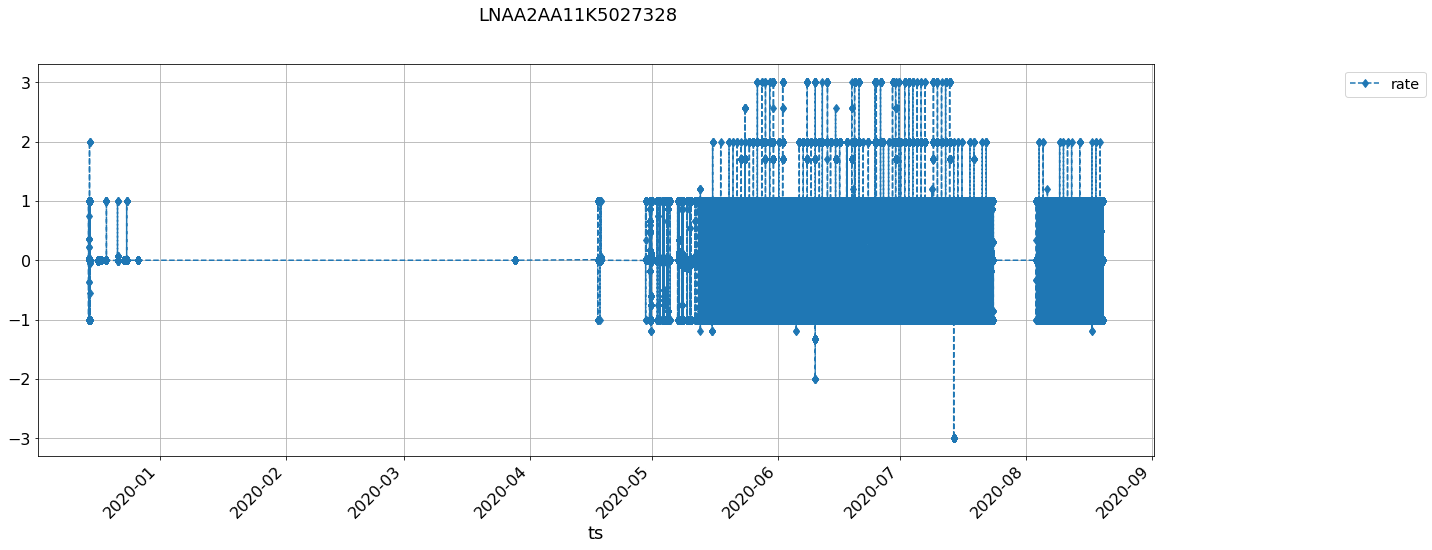

In [54]:
%matplotlib inline
result_list_pd2['rate'].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    #xlim=(earliest_date_ - timedelta(2), prod_date_ + timedelta(3)),
    #title='LNAA2AA11K5027328', fontsize=18
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5028947', fontsize=18)

In [58]:
result_list_pd2.head()

,rate
ts,
2020-04-30 18:00:35,NaN
2020-04-30 18:00:45,NaN
2020-04-30 18:00:55,NaN
2020-04-30 18:01:05,NaN
2020-04-30 18:01:15,NaN


In [59]:
%matplotlib inline
result_list_pd2['rate'].iloc[355677:].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    xlim=(pd.TimeStamp('2020-8-1 01:00:00'), ),
    #title='LNAA2AA11K5027328', fontsize=18
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5028947', fontsize=18)

AttributeError: 'module' object has no attribute 'TimeStamp'